**Bias in AI-Based Traffic Ticketing: Analyzing Disproportionate Impacts on Racial Groups and Demographic Disparities**

**SAN FRANSISCO**

**Step 1: Load the Dataset and Preprocess the Data**

In [ ]:
import pandas as pd
import zipfile
import os

# Loading data
# Defining paths
zip_path = '/content/yg821jf8611_ca_san_francisco_2020_04_01.csv.zip'
extract_path = '/content/'

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted files:", os.listdir(extract_path))

csv_file = os.path.join(extract_path, 'ca_san_francisco_2020_04_01.csv')
df = pd.read_csv(csv_file)
df.head()

Extracted files: ['.config', 'yg821jf8611_ca_san_francisco_2020_04_01.csv.zip', 'ca_san_francisco_2020_04_01.csv', 'sample_data']


<ipython-input-1-11bed0133a1b>:21: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


,raw_row_number,date,time,location,lat,lng,district,subject_age,subject_race,subject_sex,...,citation_issued,warning_issued,outcome,contraband_found,search_conducted,search_vehicle,search_basis,reason_for_stop,raw_search_vehicle_description,raw_result_of_contact_description
0,869921,2014-08-01,00:01:00,MASONIC AV & FELL ST,37.773004,-122.445873,NaN,NaN,asian/pacific islander,female,...,False,True,warning,NaN,False,False,NaN,Mechanical or Non-Moving Violation (V.C.),No Search,Warning
1,869922,2014-08-01,00:01:00,GEARY&10TH AV,37.780898,-122.468586,NaN,NaN,black,male,...,True,False,citation,NaN,False,False,NaN,Mechanical or Non-Moving Violation (V.C.),No Search,Citation
2,869923,2014-08-01,00:15:00,SUTTER N OCTAVIA ST,37.786919,-122.426718,NaN,NaN,hispanic,male,...,True,False,citation,NaN,False,False,NaN,Mechanical or Non-Moving Violation (V.C.),No Search,Citation
3,869924,2014-08-01,00:18:00,3RD ST & DAVIDSON,37.746380,-122.392005,NaN,NaN,hispanic,male,...,False,True,warning,NaN,False,False,NaN,Mechanical or Non-Moving Violation (V.C.),No Search,Warning
4,869925,2014-08-01,00:19:00,DIVISADERO ST. & BUSH ST.,37.786348,-122.440003,NaN,NaN,white,male,...,True,False,citation,NaN,False,False,NaN,Mechanical or Non-Moving Violation (V.C.),No Search,Citation


Exploratory data analysis and data cleaning

In [ ]:

print("DataFrame shape:", df.shape)

print("\nFeatures:")
print(df.columns.tolist())
print("\nData Types:")
print(df.dtypes)

# Checking for missing values in each column
print("\nMissing Values (per column):")
print(df.isnull().sum())

DataFrame shape: (905070, 22)

Features:
['raw_row_number', 'date', 'time', 'location', 'lat', 'lng', 'district', 'subject_age', 'subject_race', 'subject_sex', 'type', 'arrest_made', 'citation_issued', 'warning_issued', 'outcome', 'contraband_found', 'search_conducted', 'search_vehicle', 'search_basis', 'reason_for_stop', 'raw_search_vehicle_description', 'raw_result_of_contact_description']

Data Types:
raw_row_number                        object
date                                  object
time                                  object
location                              object
lat                                  float64
lng                                  float64
district                              object
subject_age                          float64
subject_race                          object
subject_sex                           object
type                                  object
arrest_made                             bool
citation_issued                         bool
warning

In [ ]:
import pandas as pd

# Checking for missing values before handling
print("\n🔍 Missing Values Before Handling:")
print(df.isnull().sum())

# Converting relevant columns to categorical first (if not already)
categorical_cols = ['subject_race', 'subject_sex', 'raw_descent_description', 'type',
                    'reason_for_stop', 'search_basis', 'outcome', 'contraband_found']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# Dropping rows where 'date' or 'type' is missing (critical for time-series/event-type analysis)
df = df.dropna(subset=['date', 'type'])

# Handling 'region' (if exists) and 'officer_id_hash' - keep unknown for bias audits
if 'region' in df.columns:
    df['region'] = df['region'].astype('category')
    df['region'] = df['region'].cat.add_categories("unknown")
    df['region'] = df['region'].fillna("unknown")

if 'officer_id_hash' in df.columns:
    df['officer_id_hash'] = df['officer_id_hash'].fillna("unknown")

# Filling object-type or categorical columns with 'unknown'
bias_related_cols = ['reason_for_stop', 'search_basis', 'outcome', 'contraband_found']
for col in bias_related_cols:
    if col in df.columns:
        if df[col].dtype.name == 'category':
            df[col] = df[col].cat.add_categories("unknown")
        df[col] = df[col].fillna("unknown")

# Filling numeric columns with median
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Converting categorical text fields to lowercase for consistency
text_cats = ['subject_race', 'subject_sex', 'raw_descent_description', 'type']
for col in text_cats:
    if col in df.columns:
        df[col] = df[col].astype(str).str.lower()

# Standardizing 'subject_sex' to male/female/unknown
df['subject_sex'] = df['subject_sex'].apply(lambda x: x if x in ['male', 'female'] else 'unknown')

# Final check
print("\n Missing Values After Handling:")
print(df.isnull().sum())

print("\nSummary Statistics:")
print(df.describe(include='all'))

print("\n First 5 Rows:")
print(df.head())



🔍 Missing Values Before Handling:
raw_row_number                         2455
date                                      0
time                                     35
location                                 43
lat                                    1697
lng                                    1697
district                                  0
subject_age                               0
subject_race                              0
subject_sex                               0
type                                      0
arrest_made                               0
citation_issued                           0
warning_issued                            0
outcome                               15681
contraband_found                     851689
search_conducted                          0
search_vehicle                            0
search_basis                         851689
reason_for_stop                        2212
raw_search_vehicle_description            0
raw_result_of_contact_description        

In [ ]:
# Step 4: Feature Engineering
# Extract year, month, and hour from the date and time columns
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['hour'] = pd.to_datetime(df['time'], format='%H:%M:%S', errors='coerce').dt.hour

# Create a binary column for nighttime stops (7 PM - 6 AM)
df['is_night'] = df['hour'].apply(lambda x: 1 if (x >= 19 or x <= 6) else 0)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initializing separate LabelEncoders for each column
race_encoder = LabelEncoder()
sex_encoder = LabelEncoder()
type_encoder = LabelEncoder()

# Encoding categorical columns and storing in new columns
df['subject_race_encoded'] = race_encoder.fit_transform(df['subject_race'])
df['subject_sex_encoded'] = sex_encoder.fit_transform(df['subject_sex'])
df['type_encoded'] = type_encoder.fit_transform(df['type'])

# Optionally, check the mappings
print("\n Label Mappings:")
print("Race:", dict(zip(race_encoder.classes_, race_encoder.transform(race_encoder.classes_))))
print("Sex:", dict(zip(sex_encoder.classes_, sex_encoder.transform(sex_encoder.classes_))))
print("Type:", dict(zip(type_encoder.classes_, type_encoder.transform(type_encoder.classes_))))

# Show first few rows to confirm encoding
print("\nEncoded Data Preview:")
print(df[['subject_race', 'subject_race_encoded', 'subject_sex', 'subject_sex_encoded', 'type', 'type_encoded']].head())



🔍 Label Mappings:
Race: {'asian/pacific islander': np.int64(0), 'black': np.int64(1), 'hispanic': np.int64(2), 'other': np.int64(3), 'white': np.int64(4)}
Sex: {'female': np.int64(0), 'male': np.int64(1)}
Type: {'vehicular': np.int64(0)}

🧾 Encoded Data Preview:
             subject_race  subject_race_encoded subject_sex  \
0  asian/pacific islander                     0      female   
1                   black                     1        male   
2                hispanic                     2        male   
3                hispanic                     2        male   
4                   white                     4        male   

   subject_sex_encoded       type  type_encoded  
0                    0  vehicular             0  
1                    1  vehicular             0  
2                    1  vehicular             0  
3                    1  vehicular             0  
4                    1  vehicular             0  


In [ ]:
# Step 6: Saving the Cleaned Data
# Save the processed dataset
df.to_csv("processed_data.csv", index=False)
print("Data Preprocessing Completed & Saved!")

Data Preprocessing Completed & Saved!


**Step 2: Exploratory Data Analysis**

In [ ]:
# Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Setting visualization style
sns.set(style="whitegrid")

# Loading the processed dataset
df = pd.read_csv("processed_data.csv")

**Traffic Stops by Race & Gender- This plot helps visualize racial and gender disparities in traffic stops**

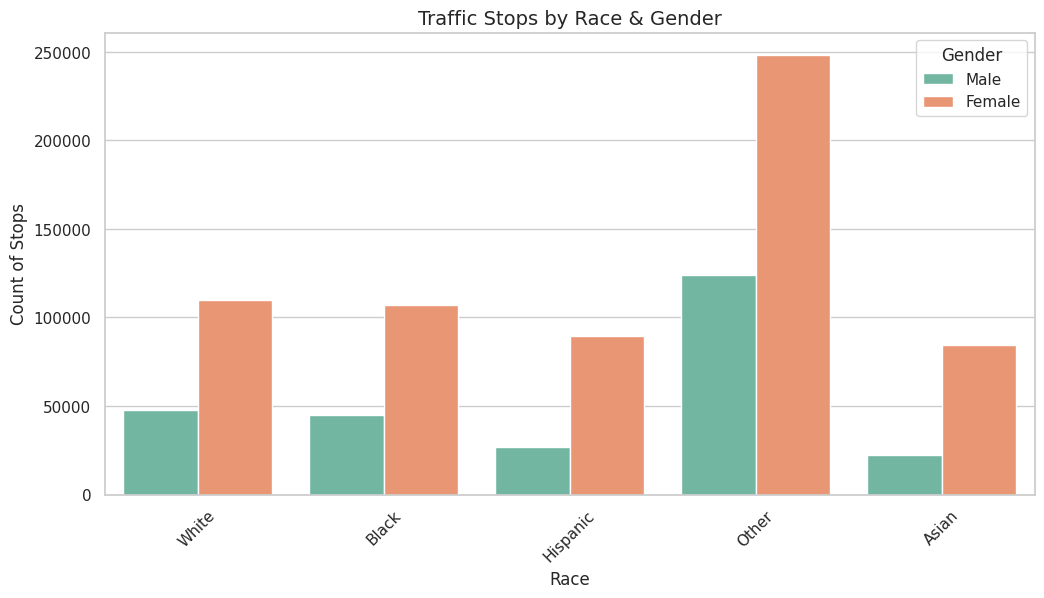

In [ ]:
# Defining mappings for race and gender labels
race_mapping = {0: "White", 1: "Black", 2: "Hispanic", 3: "Asian", 4: "Other"}
gender_mapping = {0: "Male", 1: "Female"}

# Replacing encoded values with actual labels
df["subject_race_label"] = df["subject_race_encoded"].replace(race_mapping)
df["subject_sex_label"] = df["subject_sex_encoded"].replace(gender_mapping)

# Plot with labels
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="subject_race_label", hue="subject_sex_label", palette="Set2")
plt.title("Traffic Stops by Race & Gender", fontsize=14)
plt.xlabel("Race")
plt.ylabel("Count of Stops")
plt.xticks(rotation=45)
plt.legend(title="Gender")
plt.show()

**Traffic Stop Rate by District & Region**

<Figure size 1800x1200 with 0 Axes>

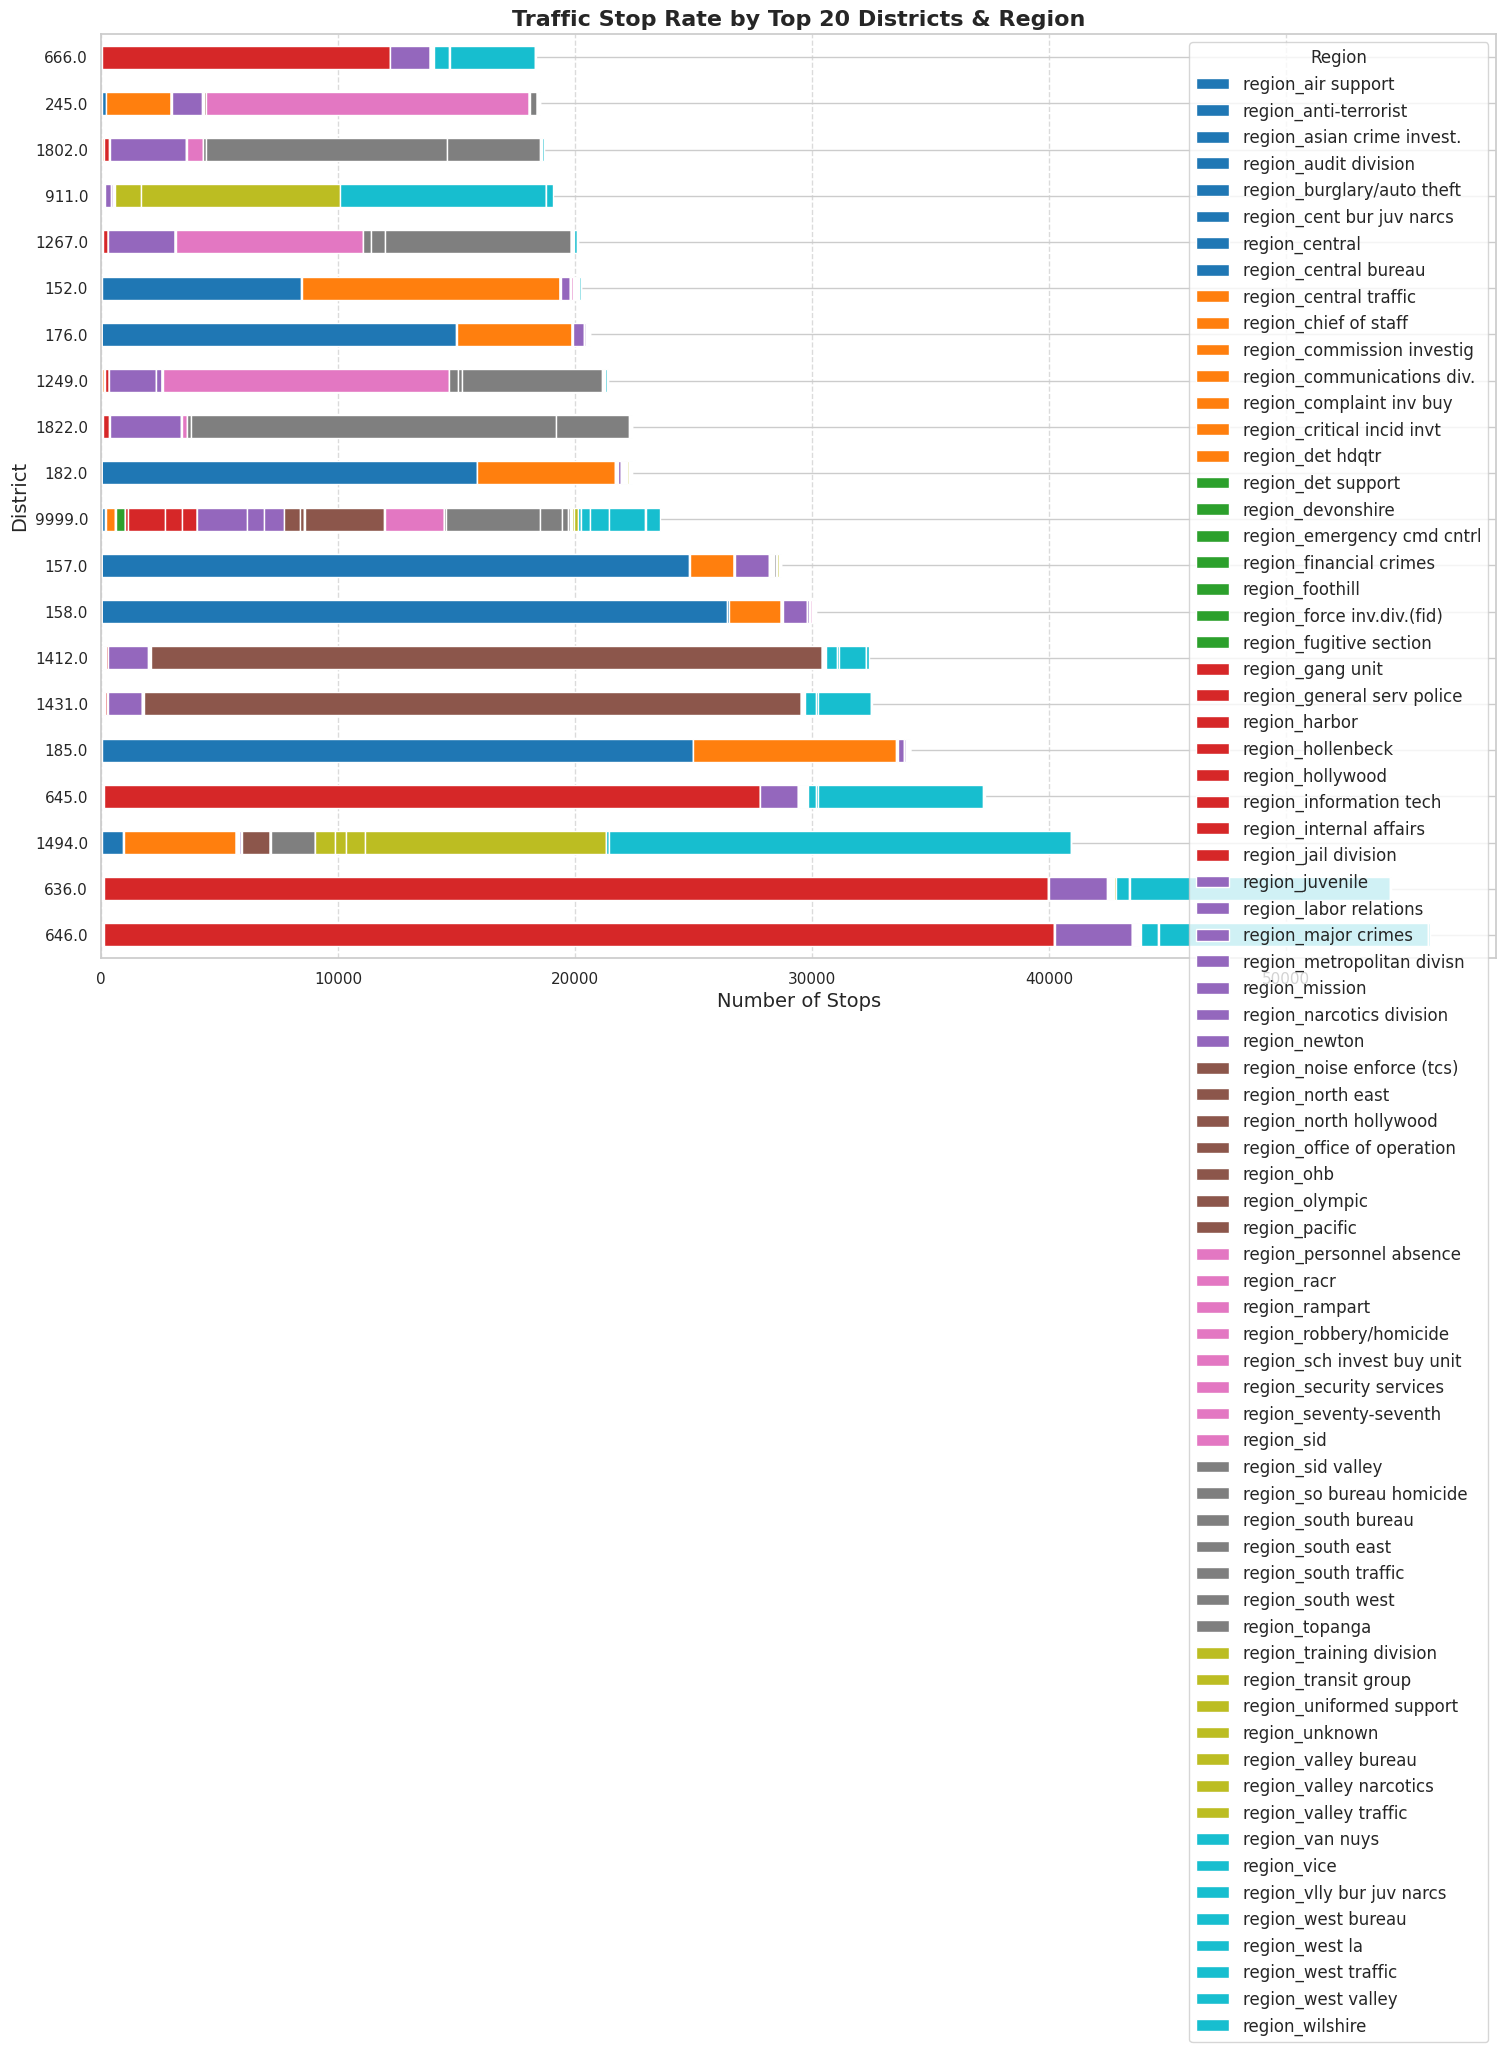

In [ ]:
'''import matplotlib.pyplot as plt

# ✅ Select region columns dynamically
region_columns = [col for col in df.columns if col.startswith('region_')]

# ✅ Create a new column for the region by combining the existing ones
df['region'] = df[region_columns].idxmax(axis=1)  # Get the name of the column with the highest value for each row

# ✅ Group by district and the newly created region column
district_region_counts = df.groupby(['district', 'region']).size().unstack(fill_value=0)

# ✅ Sort districts by total stops and keep only top 20
top_districts = district_region_counts.sum(axis=1).sort_values(ascending=False).head(20)
district_region_counts = district_region_counts.loc[top_districts.index]

# ✅ Plot the graph
plt.figure(figsize=(18, 12))
district_region_counts.plot(kind="barh", stacked=True, colormap="tab10", figsize=(18, 12))

# ✅ Customize the plot
plt.title("Traffic Stop Rate by Top 20 Districts & Region", fontsize=16, fontweight='bold')
plt.xlabel("Number of Stops", fontsize=14)
plt.ylabel("District", fontsize=14)
plt.legend(title="Region", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.7)

# ✅ Show the plot
plt.show()'''

**Violation Type Analysis (Pedestrian vs. Vehicular)**

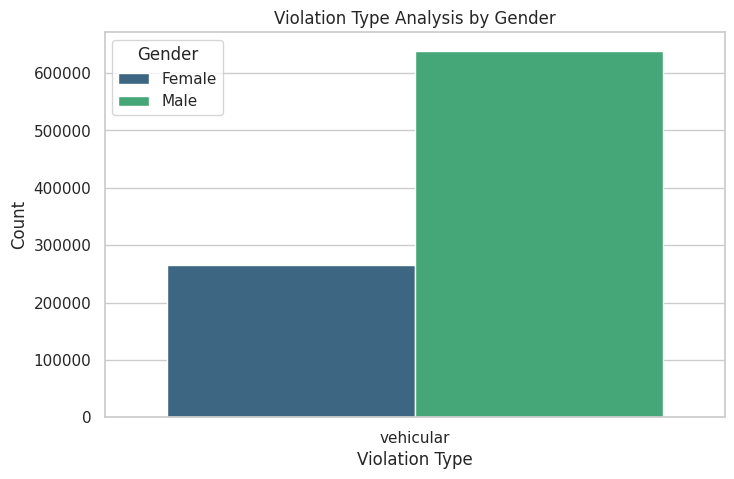

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="type", hue="subject_sex", palette="viridis")

plt.title("Violation Type Analysis by Gender")
plt.xlabel("Violation Type")
plt.ylabel("Count")
plt.legend(title="Gender", labels=["Female", "Male"])  # Explicitly setting labels

plt.show()

**Temporal Analysis (Bias Patterns Based on Time & Year)- If certain years saw spikes in stops, it might correlate with policy changes or events**

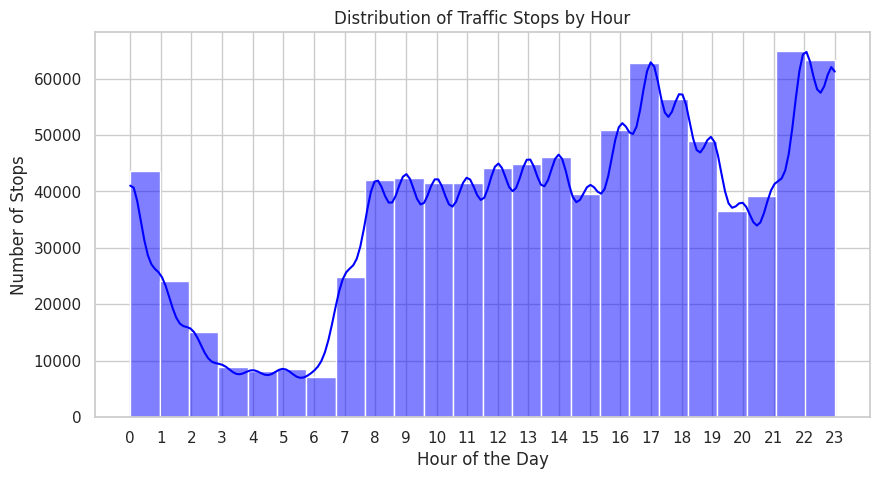

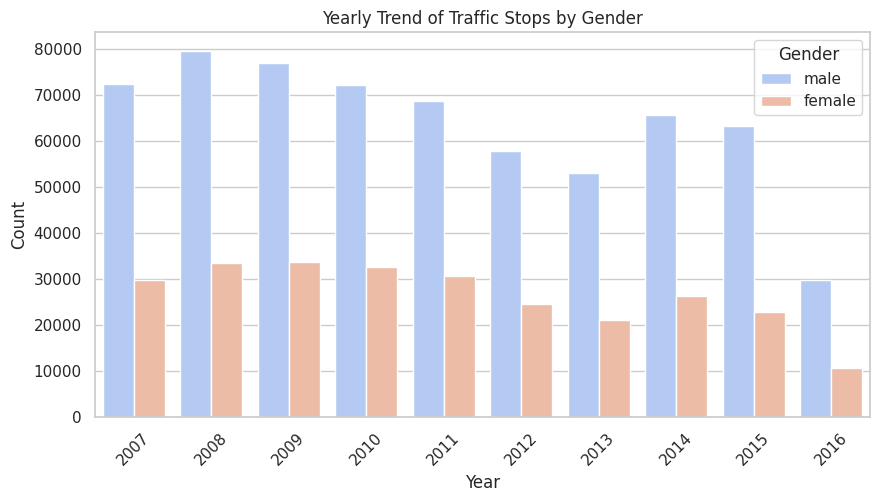

In [ ]:
# Stops by Hour of the Day
plt.figure(figsize=(10, 5))
sns.histplot(df['hour'], bins=24, kde=True, color="blue")
plt.title("Distribution of Traffic Stops by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Stops")
plt.xticks(range(0, 24))
plt.show()

# Stops Over the Years

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="year", hue="subject_sex", palette="coolwarm")
plt.title("Yearly Trend of Traffic Stops by Gender")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Gender")
plt.show()


**Are Minority Groups Stopped More at Night?**

In [ ]:
print(df.columns.tolist())


['raw_row_number', 'date', 'time', 'location', 'lat', 'lng', 'district', 'subject_age', 'subject_race', 'subject_sex', 'type', 'arrest_made', 'citation_issued', 'warning_issued', 'outcome', 'contraband_found', 'search_conducted', 'search_vehicle', 'search_basis', 'reason_for_stop', 'raw_search_vehicle_description', 'raw_result_of_contact_description', 'year', 'month', 'hour', 'is_night', 'subject_race_encoded', 'subject_sex_encoded', 'type_encoded', 'subject_race_label', 'subject_sex_label']


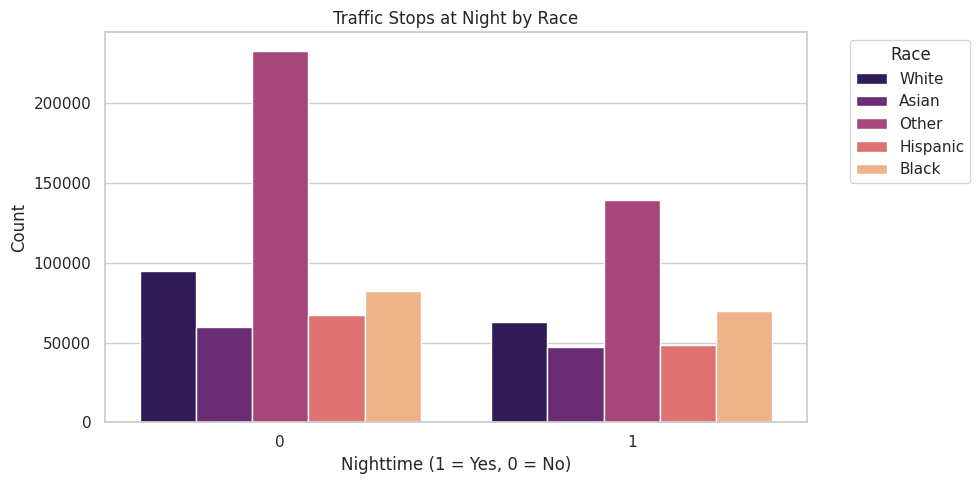

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="is_night", hue="subject_race_label", palette="magma")
plt.title("Traffic Stops at Night by Race")
plt.xlabel("Nighttime (1 = Yes, 0 = No)")
plt.ylabel("Count")
plt.legend(title="Race", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


**Step 3: Bias Detection with Fairness Metrics**

**Bias Mitigation Technique- Using Adversarial Debiasing and Reweighting as these will give both direct debiasing during training and data balancing techniques. Fairness Metrics- using Demographic Parity, and Disparate Impact. These metrics cover different aspects of fairness: Demographic Parity for overall group fairness, Disparate Impact for identifying any unintended adverse impacts.**

In [ ]:
# Getting unique values for race and sex
distinct_races = df['subject_race'].unique()
distinct_sexes = df['subject_sex'].unique()
distinct_offences= df['type'].unique()

print("Distinct subject races:", distinct_races)
print("Distinct subject sexes:", distinct_sexes)
print("Distinct subject offences:", distinct_offences)

Distinct subject races: ['asian/pacific islander' 'black' 'hispanic' 'white' 'other']
Distinct subject sexes: ['female' 'male']
Distinct subject offences: ['vehicular']


In [ ]:
df.head()

,raw_row_number,date,time,location,lat,lng,district,subject_age,subject_race,subject_sex,...,raw_result_of_contact_description,year,month,hour,is_night,subject_race_encoded,subject_sex_encoded,type_encoded,subject_race_label,subject_sex_label
0,869921.0,2014-08-01,00:01:00,MASONIC AV & FELL ST,37.773004,-122.445873,-1.0,35.0,asian/pacific islander,female,...,Warning,2014,8,0.0,1,0,0,0,White,Male
1,869922.0,2014-08-01,00:01:00,GEARY&10TH AV,37.780898,-122.468586,-1.0,35.0,black,male,...,Citation,2014,8,0.0,1,1,1,0,Black,Female
2,869923.0,2014-08-01,00:15:00,SUTTER N OCTAVIA ST,37.786919,-122.426718,-1.0,35.0,hispanic,male,...,Citation,2014,8,0.0,1,2,1,0,Hispanic,Female
3,869924.0,2014-08-01,00:18:00,3RD ST & DAVIDSON,37.746380,-122.392005,-1.0,35.0,hispanic,male,...,Warning,2014,8,0.0,1,2,1,0,Hispanic,Female
4,869925.0,2014-08-01,00:19:00,DIVISADERO ST. & BUSH ST.,37.786348,-122.440003,-1.0,35.0,white,male,...,Citation,2014,8,0.0,1,4,1,0,Other,Female


In [ ]:
print("Unique values in 'type':", df['type'].unique())
print("Value counts for 'type':\n", df['type'].value_counts())


Unique values in 'type': ['vehicular']
Value counts for 'type':
 type
vehicular    905070
Name: count, dtype: int64


Only vehicular

🔹 Overall citation probability: 0.6979128686178969

🔹 Citation probability by race:
 subject_race_label
Asian       0.762189
Black       0.549594
Hispanic    0.666876
Other       0.713718
White       0.783028
Name: positive_outcome, dtype: float64

🔹 Parity difference (race):
 subject_race_label
Asian       0.064276
Black      -0.148319
Hispanic   -0.031036
Other       0.015805
White       0.085115
Name: positive_outcome, dtype: float64

🔹 Parity ratio (race):
 subject_race_label
Asian       1.092098
Black       0.787482
Hispanic    0.955530
Other       1.022646
White       1.121957
Name: positive_outcome, dtype: float64

🔸 Citation probability by sex:
 subject_sex_label
Female    0.694535
Male      0.706035
Name: positive_outcome, dtype: float64

🔸 Parity difference (sex):
 subject_sex_label
Female   -0.003378
Male      0.008122
Name: positive_outcome, dtype: float64

🔸 Parity ratio (sex):
 subject_sex_label
Female    0.995160
Male      1.011637
Name: positive_outcome, dtype: float64


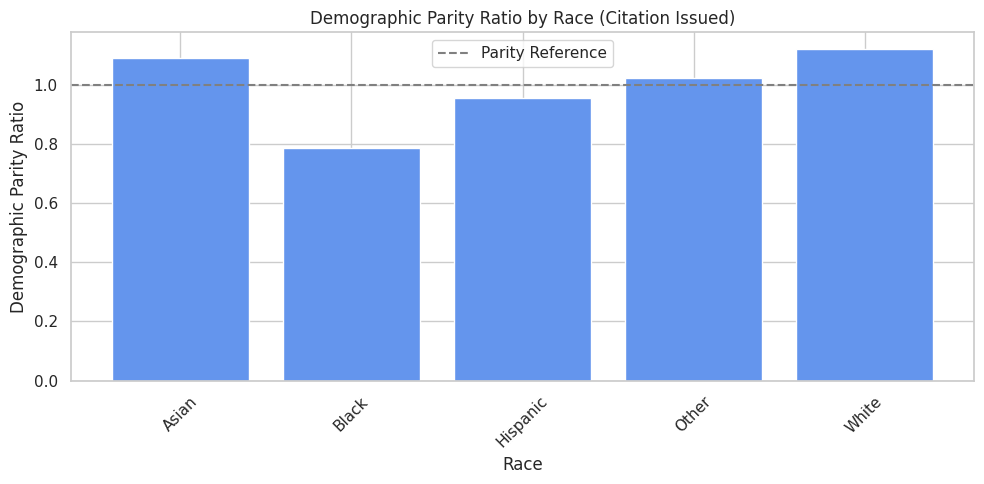

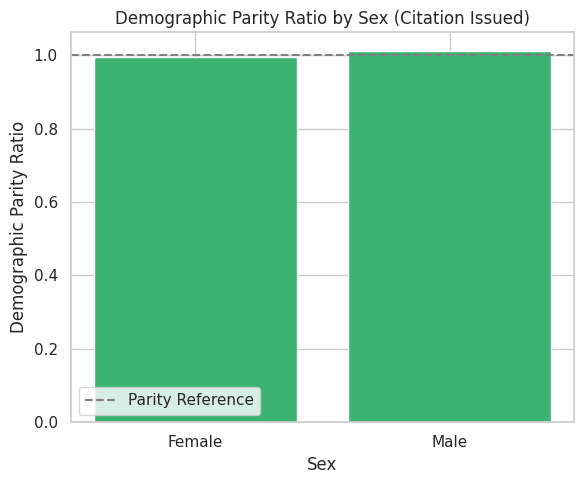

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define outcome: 1 if citation issued, 0 otherwise
df['positive_outcome'] = df['citation_issued'].astype(int)

# Use cleaned/standardized labels if available
race_col = 'subject_race_label' if 'subject_race_label' in df.columns else 'subject_race'
sex_col = 'subject_sex_label' if 'subject_sex_label' in df.columns else 'subject_sex'

# Optional: Filter for specific year
# df = df[df['year'] == 2022]

# RACE ANALYSIS
overall_prob = df['positive_outcome'].mean()
race_prob = df.groupby(race_col)['positive_outcome'].mean()
race_parity_diff = race_prob - overall_prob
race_parity_ratio = race_prob / overall_prob

print("🔹 Overall citation probability:", overall_prob)
print("\n🔹 Citation probability by race:\n", race_prob)
print("\n🔹 Parity difference (race):\n", race_parity_diff)
print("\n🔹 Parity ratio (race):\n", race_parity_ratio)

# SEX ANALYSIS
sex_prob = df.groupby(sex_col)['positive_outcome'].mean()
sex_parity_diff = sex_prob - overall_prob
sex_parity_ratio = sex_prob / overall_prob

print("\n🔸 Citation probability by sex:\n", sex_prob)
print("\n🔸 Parity difference (sex):\n", sex_parity_diff)
print("\n🔸 Parity ratio (sex):\n", sex_parity_ratio)

# PLOT: Race
plt.figure(figsize=(10, 5))
plt.bar(race_prob.index, race_parity_ratio, color='cornflowerblue')
plt.axhline(1, color='gray', linestyle='--', label="Parity Reference")
plt.ylabel('Demographic Parity Ratio')
plt.xlabel('Race')
plt.title('Demographic Parity Ratio by Race (Citation Issued)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# PLOT: Sex
plt.figure(figsize=(6, 5))
plt.bar(sex_prob.index, sex_parity_ratio, color='mediumseagreen')
plt.axhline(1, color='gray', linestyle='--', label="Parity Reference")
plt.ylabel('Demographic Parity Ratio')
plt.xlabel('Sex')
plt.title('Demographic Parity Ratio by Sex (Citation Issued)')
plt.legend()
plt.tight_layout()
plt.show()


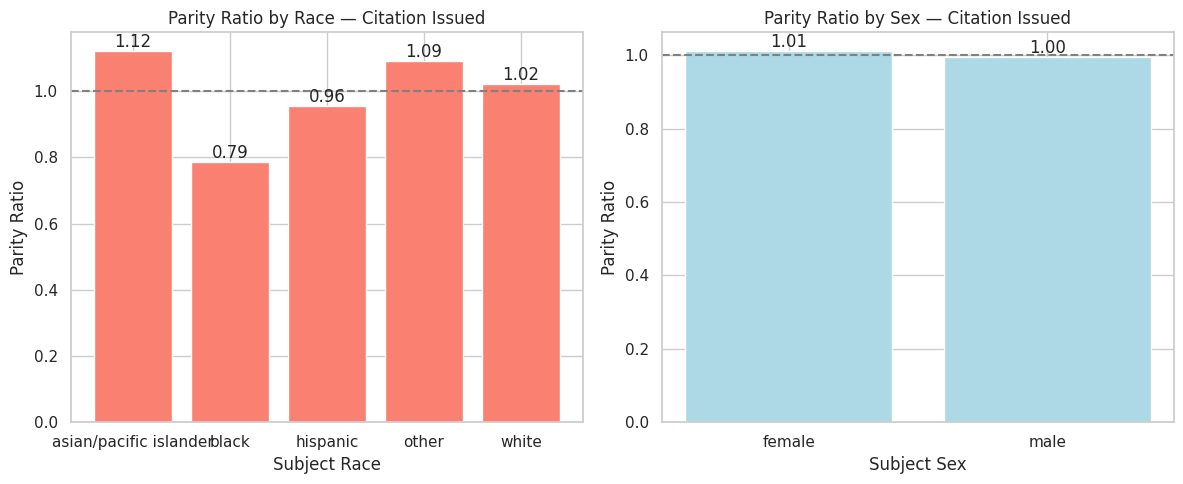

In [ ]:
import matplotlib.pyplot as plt

# 1) Defining a positive outcome: citation issued (1) vs not (0)
pos = df['citation_issued'] == 1

# 2) Overall citation rate
p_pos = pos.mean()

# 3) Group-conditional rates
race_rate = df.groupby('subject_race')['citation_issued'].mean()
sex_rate  = df.groupby('subject_sex' )['citation_issued'].mean()

# 4) Parity ratios
race_parity = race_rate / p_pos
sex_parity  = sex_rate  / p_pos

# 5) Plot
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].bar(race_parity.index, race_parity, color='salmon')
ax[0].axhline(1, color='gray', linestyle='--')
ax[0].set(title="Parity Ratio by Race — Citation Issued",
          ylabel="Parity Ratio", xlabel="Subject Race")
for b in ax[0].patches:
    ax[0].annotate(f"{b.get_height():.2f}",
                   (b.get_x()+b.get_width()/2, b.get_height()),
                   ha='center', va='bottom')

ax[1].bar(sex_parity.index, sex_parity, color='lightblue')
ax[1].axhline(1, color='gray', linestyle='--')
ax[1].set(title="Parity Ratio by Sex — Citation Issued",
          ylabel="Parity Ratio", xlabel="Subject Sex")
for b in ax[1].patches:
    ax[1].annotate(f"{b.get_height():.2f}",
                   (b.get_x()+b.get_width()/2, b.get_height()),
                   ha='center', va='bottom')

plt.tight_layout()
plt.show()


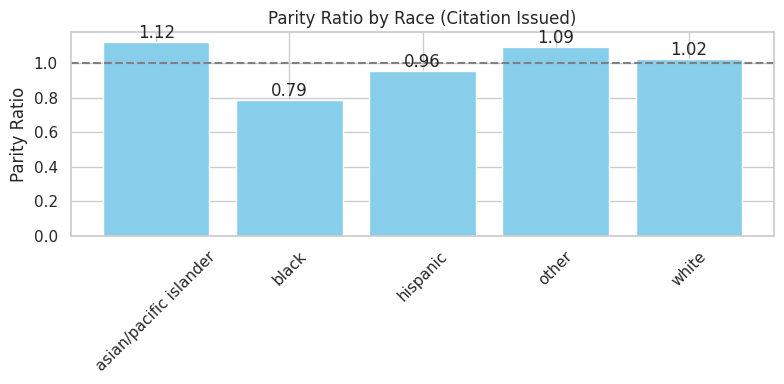

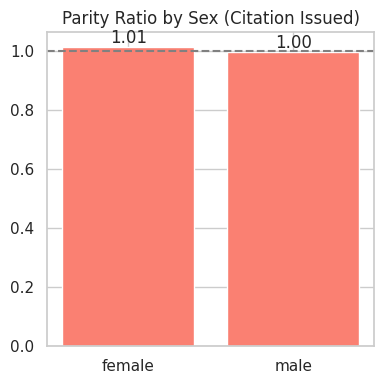

In [ ]:
#Rewighting
#Vehicular

import matplotlib.pyplot as plt

# 1) Defining a binary outcome that varies
df['positive_outcome'] = df['citation_issued'].astype(int)

# 2) Overall probability P(Y=1)
p_y = df['positive_outcome'].mean()

# 3) Group‐conditional probabilities P(Y=1 | G=race)
race_rate = df.groupby('subject_race')['positive_outcome'].mean()
sex_rate  = df.groupby('subject_sex' )['positive_outcome'].mean()

# 4) Parity ratios
race_parity = race_rate / p_y
sex_parity  = sex_rate  / p_y

# 5) Plot by race
plt.figure(figsize=(8,4))
bars = plt.bar(race_parity.index, race_parity, color='skyblue')
plt.axhline(1, linestyle='--', color='gray')
plt.title("Parity Ratio by Race (Citation Issued)")
plt.ylabel("Parity Ratio")
plt.xticks(rotation=45)
for b in bars:
    plt.text(b.get_x()+b.get_width()/2, b.get_height(), f"{b.get_height():.2f}",
             ha='center', va='bottom')
plt.tight_layout()
plt.show()

# 6) Plot by sex
plt.figure(figsize=(4,4))
bars = plt.bar(sex_parity.index, sex_parity, color='salmon')
plt.axhline(1, linestyle='--', color='gray')
plt.title("Parity Ratio by Sex (Citation Issued)")
for b in bars:
    plt.text(b.get_x()+b.get_width()/2, b.get_height(), f"{b.get_height():.2f}",
             ha='center', va='bottom')
plt.tight_layout()
plt.show()



In [ ]:
# 1) Defining positive outcome as “got a citation”
df['positive_outcome'] = df['citation_issued'].astype(int)

# 2) Recompute P(Y=y)
n   = len(df)
p_y = df['positive_outcome'].value_counts(normalize=True)

# 3) P(G=g) by race
p_g = df['subject_race'].value_counts(normalize=True)

# 4) Joint P(G=g, Y=y)
joint = df.groupby(['subject_race','positive_outcome']).size().divide(n)

# 5) Compute weights
weights = {
    (g,y): (p_g[g] * p_y[y]) / joint.loc[(g,y)]
    for g,y in joint.index
}

# 6) Turn into a DataFrame
weights_df = (
    pd.Series(weights)
      .rename("weight")
      .reset_index()
      .rename(columns={"level_0":"subject_race","level_1":"positive_outcome"})
)
print(weights_df)

# 7) Applying to each row
df['sample_weight'] = df.apply(
    lambda r: weights.get((r['subject_race'], r['positive_outcome'])), axis=1
)

# 8) Sample check
print(df[['subject_race','positive_outcome','sample_weight']].head())


             subject_race  positive_outcome    weight
0  asian/pacific islander                 0  1.392287
1  asian/pacific islander                 1  0.891300
2                   black                 0  0.670700
3                   black                 1  1.269870
4                hispanic                 0  0.906832
5                hispanic                 1  1.046540
6                   other                 0  1.270283
7                   other                 1  0.915669
8                   white                 0  1.055208
9                   white                 1  0.977855
             subject_race  positive_outcome  sample_weight
0  asian/pacific islander                 0       1.392287
1                   black                 1       1.269870
2                hispanic                 1       1.046540
3                hispanic                 0       0.906832
4                   white                 1       0.977855


In [ ]:
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv("/content/Data/yg821jf8611_ca_san_francisco_2020_04_01.csv.zip", dtype={"district": str}, low_memory=False)  # <-- safer

# Dropping columns
drop_columns = [
    "raw_row_number", "raw_search_vehicle_description", "raw_result_of_contact_description"
]
df_cleaned = df.drop(columns=[col for col in drop_columns if col in df.columns])

# Dropping rows where critical demographic or outcome info is missing
required_columns = ["subject_race", "subject_sex", "subject_age", "reason_for_stop"]
df_cleaned = df_cleaned.dropna(subset=[col for col in required_columns if col in df_cleaned.columns])

# Making a clean copy
df_cleaned = df_cleaned.copy()

# Filling missing values in boolean-like columns
for col in ["search_conducted", "search_vehicle"]:
    if col in df_cleaned.columns:
        df_cleaned[col] = df_cleaned[col].fillna(False)

# Filling missing reason_for_stop if needed
if "reason_for_stop" in df_cleaned.columns:
    df_cleaned["reason_for_stop"] = df_cleaned["reason_for_stop"].fillna("Unknown")

# Converting boolean-like columns to proper booleans
for col in ["search_conducted", "search_vehicle"]:
    if col in df_cleaned.columns:
        df_cleaned[col] = df_cleaned[col].astype(bool)

# One-hot encoding categorical variables (except target like "outcome")
categorical_cols = [
    "subject_race", "subject_sex", "reason_for_stop", "search_basis"
]
df_encoded = pd.get_dummies(df_cleaned, columns=[col for col in categorical_cols if col in df_cleaned.columns], drop_first=True)

# Final output
print(df_encoded.shape)
print(df_encoded.head())


(844223, 45)
             date      time                  location        lat         lng  \
33159  2007-01-01  10:00:00          26TH & MINNESOTA  37.751445 -122.389574   
33160  2007-01-01  10:17:00  EMBARCADERO & HOWARDA ON  37.792563 -122.390973   
33161  2007-01-01  10:25:00                1700 JUDAH  37.761562 -122.480251   
33162  2007-01-01  10:28:00          COLUMBUS/VALLEJO  37.798712 -122.407910   
33163  2007-01-01  10:35:00             FOLSOM & MOSS  37.777182 -122.407335   

      district  subject_age       type  arrest_made  citation_issued  ...  \
33159        C         56.0  vehicular        False             True  ...   
33160        B         32.0  vehicular        False             True  ...   
33161        I         57.0  vehicular        False             True  ...   
33162        A         31.0  vehicular        False            False  ...   
33163        J         37.0  vehicular        False             True  ...   

       reason_for_stop_Moving Violation|Mec

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Starting from the cleaned San Francisco data
df_fairness = df_cleaned.copy()

# Defining the target and protected attribute
target_col = "search_conducted"  # (binary yes/no action)
protected_col = "subject_race"

# Dropping rows where target or protected attribute is missing
df_fairness = df_fairness.dropna(subset=[target_col, protected_col])

# Making sure target is binary 1/0
df_fairness[target_col] = df_fairness[target_col].astype(bool).astype(int)

# Standardizing the protected attribute (lowercase, clean)
df_fairness[protected_col] = df_fairness[protected_col].astype(str).str.strip().str.lower()

# Defining groups
privileged_group = "white"
unprivileged_group = "black"

# Computing search rates
total_privileged = df_fairness[df_fairness[protected_col] == privileged_group][target_col].mean()
total_unprivileged = df_fairness[df_fairness[protected_col] == unprivileged_group][target_col].mean()

# Computing disparate impact (protect against divide-by-zero)
disparate_impact = total_unprivileged / total_privileged if total_privileged != 0 else None

print("Privileged group (white) search rate:", total_privileged)
print("Unprivileged group (black) search rate:", total_unprivileged)
print("Disparate Impact (unprivileged / privileged):", disparate_impact)


Privileged group (white) search rate: 0.03153429608040718
Unprivileged group (black) search rate: 0.15238880897989113
Disparate Impact (unprivileged / privileged): 4.8324785367437775


So basically, the privileged group (white individuals) had a search rate of about 3.15%, meaning very few white individuals who were stopped ended up being searched. In contrast, the unprivileged group (Black individuals) had a much higher search rate of 15.24%, meaning they were searched much more frequently after being stopped. When we calculate the disparate impact, it comes out to about 4.83, which tells us that Black individuals were searched nearly five times more often than white individuals. This is a significant disparity and strongly suggests the presence of systemic bias or unfairness in how searches were being conducted in the San Francisco dataset.


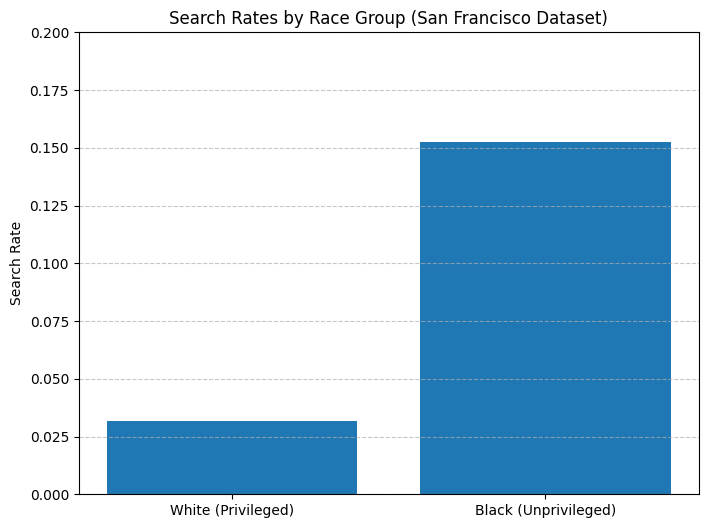

In [ ]:
import matplotlib.pyplot as plt

# Values from the user's output
groups = ['White (Privileged)', 'Black (Unprivileged)']
search_rates = [0.03153429608040718, 0.15238880897989113]

# Create bar plot
plt.figure(figsize=(8, 6))
plt.bar(groups, search_rates)
plt.ylabel('Search Rate')
plt.title('Search Rates by Race Group (San Francisco Dataset)')
plt.ylim(0, 0.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Step 1: Loading preprocessed San Francisco data
df = df_cleaned.copy()

# Step 2: Downsampling if very large (optional)
df_sample = df.sample(n=10000, random_state=42) if len(df) > 10000 else df.copy()

# Step 3: Defining target and protected attribute
target_col = "search_conducted"  # action we're predicting
protected_col = "subject_race"

# Step 4: Creating binary sensitive attribute (black vs others)
df_sample["subject_race_black"] = (df_sample[protected_col].astype(str).str.lower() == "black").astype(int)
sensitive_col = "subject_race_black"

# Step 5: Selecting numeric features
X = df_sample.drop(columns=[target_col, "date"], errors="ignore").select_dtypes(include=[np.number])

# Filling any NaNs with column medians
X = X.fillna(X.median())

# Defining target and sensitive arrays
y = df_sample[target_col].astype(int).values
s = df_sample[sensitive_col].astype(int).values

# Step 6: Train-test split
X_train_full, X_test, y_train_full, y_test, s_train_full, s_test = train_test_split(
    X, y, s, test_size=0.3, random_state=42
)

# Step 7: Further splitting train into classifier-train and adversary-validation
X_train_clf, X_val_adv, y_train_clf, y_val_adv, s_train_clf, s_val_adv = train_test_split(
    X_train_full, y_train_full, s_train_full, test_size=0.2, random_state=42
)

# Step 8: Training classifier (predicting search_conducted)
clf = LogisticRegression(max_iter=500)
clf.fit(X_train_clf, y_train_clf)
y_pred = clf.predict(X_test)
clf_accuracy = accuracy_score(y_test, y_pred)

# Step 9: Train adversary (predicting race from classifier output)
val_preds = clf.predict_proba(X_val_adv)[:, 1].reshape(-1, 1)
adv = LogisticRegression()
adv.fit(val_preds, s_val_adv)

# Step 10: Evaluating adversary
test_preds = clf.predict_proba(X_test)[:, 1].reshape(-1, 1)
adv_accuracy = accuracy_score(s_test, adv.predict(test_preds))

# Step 11: Results
print(f"✅ Classifier accuracy (search prediction): {clf_accuracy:.4f}")
print(f"🧠 Adversary accuracy (race prediction): {adv_accuracy:.4f} — lower is better")


✅ Classifier accuracy (search prediction): 0.9443
🧠 Adversary accuracy (race prediction): 0.8553 — lower is better


Your classifier shows a very high accuracy of **94.4%** for predicting whether a search happens, which at first looks great, but the adversary accuracy is also very high at **85.5%**, and that's actually bad for fairness. It means the model’s outputs are strongly correlated with race — the adversary can easily guess a person’s race just from the search prediction, which signals that the classifier has learned and is likely reinforcing racial biases present in the original San Francisco dataset. Overall, while your model is performing well in pure prediction terms, it is definitely unfair and would need debiasing if used in any real-world setting.

In [ ]:
!pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 7.1 MB/s eta 0:00:00


[Epoch 0] ⚖️ Adversary-only update | Loss = 0.6520
Epoch 1: Classifier Loss = 0.6989, Adversary Loss = 0.6516
[Epoch 10] ⚖️ Adversary-only update | Loss = 0.6448
Epoch 11: Classifier Loss = 0.6605, Adversary Loss = 0.6439
[Epoch 20] ⚖️ Adversary-only update | Loss = 0.6375
Epoch 21: Classifier Loss = 0.6251, Adversary Loss = 0.6371
[Epoch 30] ⚖️ Adversary-only update | Loss = 0.6297
Epoch 31: Classifier Loss = 0.5928, Adversary Loss = 0.6287
[Epoch 40] ⚖️ Adversary-only update | Loss = 0.6232
Epoch 41: Classifier Loss = 0.5633, Adversary Loss = 0.6216
[Epoch 50] ⚖️ Adversary-only update | Loss = 0.6162
Epoch 51: Classifier Loss = 0.5359, Adversary Loss = 0.6154
[Epoch 60] ⚖️ Adversary-only update | Loss = 0.6096
Epoch 61: Classifier Loss = 0.5105, Adversary Loss = 0.6081
[Epoch 70] ⚖️ Adversary-only update | Loss = 0.6024
Epoch 71: Classifier Loss = 0.4868, Adversary Loss = 0.6012
[Epoch 80] ⚖️ Adversary-only update | Loss = 0.5956
Epoch 81: Classifier Loss = 0.4645, Adversary Loss = 0

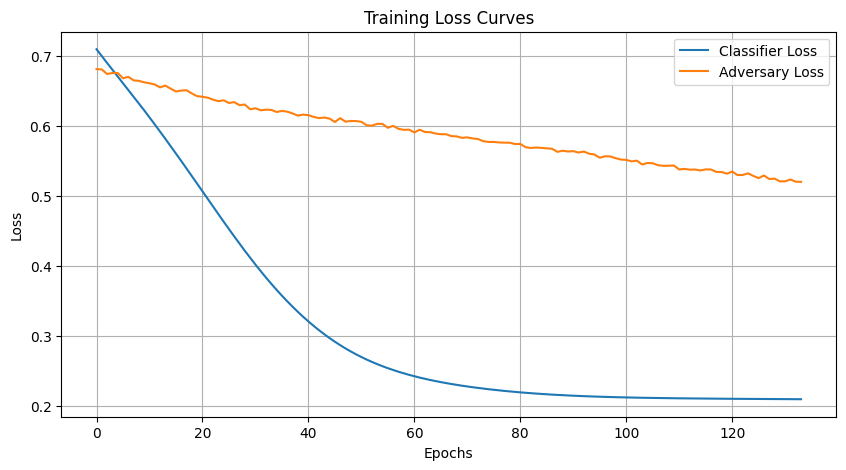

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Loading San Francisco preprocessed data
df = df_cleaned.copy()

# Downsampling
df_sample = df.sample(n=10000, random_state=42) if len(df) > 10000 else df.copy()

# sensitive attribute: subject_race_black
df_sample["subject_race_black"] = (df_sample["subject_race"].astype(str).str.lower() == "black").astype(int)

# Selecting numeric features
X = df_sample.drop(columns=["search_conducted", "date"], errors="ignore").select_dtypes(include=[np.number])

# Filling missing numeric values (important for PyTorch!)
X = X.fillna(X.median())

# Targetting and sensitive attributes
y = df_sample["search_conducted"].astype(int).values
s = df_sample["subject_race_black"].astype(int).values

# Scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(
    X_scaled, y, s, test_size=0.3, random_state=42
)

# Converting to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
s_train = torch.tensor(s_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
s_test = torch.tensor(s_test, dtype=torch.float32).unsqueeze(1)

# Defining classifier
class Classifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# Defining stronger adversary
class StrongerAdversary(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initializing models and optimizers
clf = Classifier(X_train.shape[1])
adv = StrongerAdversary(1)  # Classifier output is 1-D
clf_opt = optim.Adam(clf.parameters(), lr=1e-3)
adv_opt = optim.Adam(adv.parameters(), lr=1e-4)
bce = nn.BCELoss()

# Training loop with fairness pressure
epochs = 100
adv_weight = 5.0  # Strength of fairness penalty

for epoch in range(epochs):
    if epoch % 10 == 0:
        # Every 10 epochs: adversary-only step
        with torch.no_grad():
            y_pred = clf(X_train)
        noisy_pred = y_pred + torch.randn_like(y_pred) * 0.4
        adv_opt.zero_grad()
        s_pred = adv(noisy_pred)
        loss_adv = bce(s_pred, s_train)
        loss_adv.backward()
        adv_opt.step()
        print(f"[Epoch {epoch}] ⚖️ Adversary-only update | Loss = {loss_adv.item():.4f}")
        continue

    # --- Classifier training step ---
    clf_opt.zero_grad()
    y_pred = clf(X_train)
    noisy_pred = y_pred.detach() + torch.randn_like(y_pred) * 0.4
    s_pred = adv(noisy_pred)
    loss_clf = bce(y_pred, y_train)
    loss_adv = bce(s_pred, s_train)
    total_loss = loss_clf - adv_weight * loss_adv
    total_loss.backward()
    clf_opt.step()

    # --- Adversary training step ---
    adv_opt.zero_grad()
    s_pred = adv(noisy_pred)
    loss_adv = bce(s_pred, s_train)
    loss_adv.backward()
    adv_opt.step()

    if epoch % 10 == 1:
        print(f"Epoch {epoch}: Classifier Loss = {loss_clf.item():.4f}, Adversary Loss = {loss_adv.item():.4f}")

# Final evaluation
with torch.no_grad():
    y_test_pred = clf(X_test).round()
    s_from_y = adv(clf(X_test)).round()
    acc_clf = (y_test_pred == y_test).float().mean().item()
    acc_adv = (s_from_y == s_test).float().mean().item()

print(f"\n✅ Final Classifier Accuracy: {acc_clf:.4f}")
print(f"🧠 Final Adversary Accuracy: {acc_adv:.4f} (lower is better)")

# Plot losses
plt.figure(figsize=(10,5))
plt.plot(clf_losses, label='Classifier Loss')
plt.plot(adv_losses, label='Adversary Loss')
plt.title('Training Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

[Epoch 0] ⚖️ Adversary-only update | Loss = 0.6869
Epoch 1: Classifier Loss = 0.7097, Adversary Loss = 0.6812
[Epoch 10] ⚖️ Adversary-only update | Loss = 0.6658
Epoch 11: Classifier Loss = 0.6225, Adversary Loss = 0.6624
[Epoch 20] ⚖️ Adversary-only update | Loss = 0.6479
Epoch 21: Classifier Loss = 0.5286, Adversary Loss = 0.6465
[Epoch 30] ⚖️ Adversary-only update | Loss = 0.6318
Epoch 31: Classifier Loss = 0.4322, Adversary Loss = 0.6298
[Epoch 40] ⚖️ Adversary-only update | Loss = 0.6213
Epoch 41: Classifier Loss = 0.3500, Adversary Loss = 0.6206
[Epoch 50] ⚖️ Adversary-only update | Loss = 0.6126
Epoch 51: Classifier Loss = 0.2922, Adversary Loss = 0.6058
[Epoch 60] ⚖️ Adversary-only update | Loss = 0.6023
Epoch 61: Classifier Loss = 0.2572, Adversary Loss = 0.6030
[Epoch 70] ⚖️ Adversary-only update | Loss = 0.5920
Epoch 71: Classifier Loss = 0.2376, Adversary Loss = 0.5913
[Epoch 80] ⚖️ Adversary-only update | Loss = 0.5839
Epoch 81: Classifier Loss = 0.2263, Adversary Loss = 0

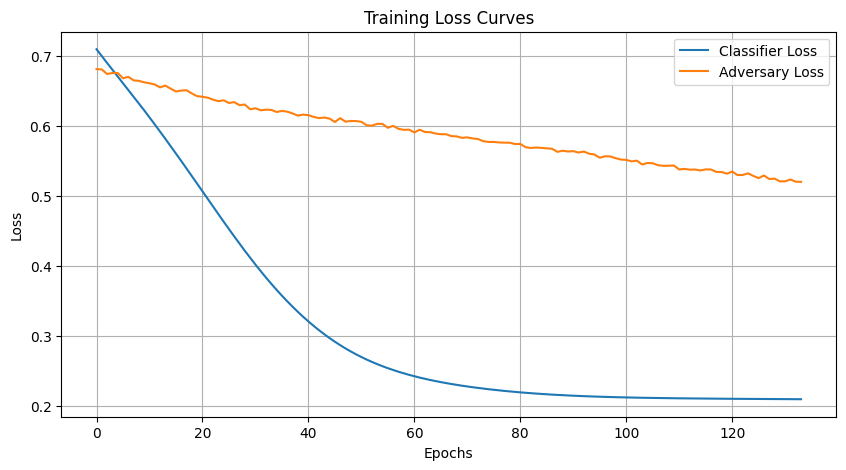

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Loading San Francisco preprocessed data
df = df_cleaned.copy()

df_sample = df.sample(n=10000, random_state=42) if len(df) > 10000 else df.copy()

df_sample["subject_race_black"] = (df_sample["subject_race"].astype(str).str.lower() == "black").astype(int)

X = df_sample.drop(columns=["search_conducted", "date"], errors="ignore").select_dtypes(include=[np.number])

X = X.fillna(X.median())

y = df_sample["search_conducted"].astype(int).values
s = df_sample["subject_race_black"].astype(int).values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(
    X_scaled, y, s, test_size=0.3, random_state=42
)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
s_train = torch.tensor(s_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
s_test = torch.tensor(s_test, dtype=torch.float32).unsqueeze(1)

class Classifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

class StrongerAdversary(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

clf = Classifier(X_train.shape[1])
adv = StrongerAdversary(1)
clf_opt = optim.Adam(clf.parameters(), lr=1e-3)
adv_opt = optim.Adam(adv.parameters(), lr=1e-4)
bce = nn.BCELoss()

epochs = 150
initial_adv_weight = 2.0
max_adv_weight = 12.0
clf_losses = []
adv_losses = []

for epoch in range(epochs):
    adv_weight = initial_adv_weight + (max_adv_weight - initial_adv_weight) * (epoch / epochs)
    noise_std = max(0.4 * (1 - epoch / (epochs * 2)), 0.2)

    if epoch % 10 == 0:
        with torch.no_grad():
            y_pred = clf(X_train)
        noisy_pred = y_pred + torch.randn_like(y_pred) * noise_std
        adv_opt.zero_grad()
        s_pred = adv(noisy_pred)
        loss_adv = bce(s_pred, s_train)
        loss_adv.backward()
        adv_opt.step()
        print(f"[Epoch {epoch}] ⚖️ Adversary-only update | Loss = {loss_adv.item():.4f}")
        continue

    clf_opt.zero_grad()
    y_pred = clf(X_train)
    noisy_pred = y_pred.detach() + torch.randn_like(y_pred) * noise_std
    s_pred = adv(noisy_pred)
    loss_clf = bce(y_pred, y_train)
    loss_adv = bce(s_pred, s_train)

    epsilon = 1e-8
    entropy = - (y_pred * torch.log(y_pred + epsilon) + (1 - y_pred) * torch.log(1 - y_pred + epsilon)).mean()
    total_loss = loss_clf + 0.01 * entropy - adv_weight * loss_adv
    total_loss.backward()
    clf_opt.step()

    # Adversary training step (three times)
    for _ in range(3):
        adv_opt.zero_grad()
        s_pred = adv(noisy_pred)
        loss_adv = bce(s_pred, s_train)
        loss_adv.backward()
        adv_opt.step()

    clf_losses.append(loss_clf.item())
    adv_losses.append(loss_adv.item())

    if epoch % 10 == 1:
        print(f"Epoch {epoch}: Classifier Loss = {loss_clf.item():.4f}, Adversary Loss = {loss_adv.item():.4f}")

    if epoch > 20 and len(clf_losses) > 20 and abs(clf_losses[-1] - clf_losses[-20]) < 0.001:
        print(f"Early stopping at epoch {epoch}")
        break

# Final evaluation
with torch.no_grad():
    y_test_pred = clf(X_test).round()
    s_from_y = adv(clf(X_test)).round()
    acc_clf = (y_test_pred == y_test).float().mean().item()
    acc_adv = (s_from_y == s_test).float().mean().item()

print(f"\n✅ Final Classifier Accuracy: {acc_clf:.4f}")
print(f"🧑‍🧬 Final Adversary Accuracy: {acc_adv:.4f} (lower is better)")

# Plot losses
plt.figure(figsize=(10,5))
plt.plot(clf_losses, label='Classifier Loss')
plt.plot(adv_losses, label='Adversary Loss')
plt.title('Training Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()